In [1]:
! pip install opencv-python
# !pip install pydot
# !pip install graphviz

Traceback (most recent call last):
  File "C:\Users\Ibtasam Ahmad\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Ibtasam Ahmad\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "e:\AI Projects\Verona_Mites\bee-image-classifier-master\bee-image-classifier-master\env\Scripts\pip.exe\__main__.py", line 4, in <module>
ModuleNotFoundError: No module named 'pip'


In [2]:
import cv2

Importing The Required Dependencies and Datasets

In [3]:
import os
# import cv2
import PIL
import zipfile
import shutil
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
import warnings
warnings.filterwarnings("ignore")
print("All the dependencies have been imported.")


All the dependencies have been imported.


In [4]:
train = "./bee_imgs/train"
test = "./bee_imgs/test"
# validation = "/kaggle/working/validation"
image_size=(256, 256)
batch_size=32
class_names=["mites"]
train_files_count = len(os.listdir(train))
test_files_count = len(os.listdir(test))

print("Number of files in train folder:", train_files_count)
print("Number of files in test folder:", test_files_count)
print("Image size considered:", image_size)
print("Batch size considered:", batch_size)
print("Class Names:", class_names)

Number of files in train folder: 3976
Number of files in test folder: 1196
Image size considered: (256, 256)
Batch size considered: 32
Class Names: ['mites']


Data Analysis and Preprocessing

In [6]:
cats = "./bee_imgs/train/"
dogs = "./bee_imgs/test/"
os.makedirs(cats, exist_ok=True)
os.makedirs(dogs, exist_ok=True)

for i, filename in enumerate(os.listdir(train)):
    if filename.startswith('cat'):
        target_path = os.path.join(cats, filename)
        # shutil.copy(os.path.join(train, filename), target_path)
        print(f"Copied cat image {i+1}/{len(os.listdir(train))}", end='\r')
    elif filename.startswith('dog'):
        target_path = os.path.join(dogs, filename)
        # shutil.copy(os.path.join(train, filename), target_path)
        print(f"Copied dog image {i+1}/{len(os.listdir(train))}", end='\r')

print("All cat and dog images have been copied to their respective directories.")
print("Number of Dog images in Dog folder:", len(os.listdir(dogs)))
print("Number of Cat images in Cat folder:", len(os.listdir(cats)))

All cat and dog images have been copied to their respective directories.
Number of Dog images in Dog folder: 1196
Number of Cat images in Cat folder: 3976


In [37]:
# train_folder = "./CatDogImgData/train"
# # zip_file_path = "/kaggle/working/train.zip"
# with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
#     for root, dirs, files in os.walk(train_folder):
#         for file in files:
#             file_path = os.path.join(root, file)
#             arcname = os.path.relpath(file_path, train_folder)
#             zipf.write(file_path, arcname=arcname)

# print(f"Train folder from {train_folder} has been successfully zipped to {zip_file_path}.")

In [7]:
paths=['./bee_imgs/train']
train_dir=None
for path in paths:
    if os.path.exists(path):
        train_dir = path
print(f"Labelled Train directory in {train_dir}")

Labelled Train directory in ./bee_imgs/train


In [8]:
if os.path.exists(train_dir):
    print("Labelled train folder uploaded into input to save future computations.")
    print("Checking number of images of each class in each class folder:")
    for class_name in class_names:
        class_folder=os.path.join(train_dir,class_name)
        if os.path.exists(class_folder) and os.path.isdir(class_folder):
            num_images = len(os.listdir(class_folder))
            print(f"Number of {class_name} images in train: {num_images}")
        else:
            print(f"Class folder '{class_name}' not found in {train_dir}")
else:
    print(f"Directory '{train_dir}' does not exist.")

Labelled train folder uploaded into input to save future computations.
Checking number of images of each class in each class folder:
Class folder 'mites' not found in ./bee_imgs/train


In [10]:
print("Data Augmentation Generator:")
data_aug=ImageDataGenerator(
            rescale=1/255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=0.3,
            fill_mode='nearest')
print(data_aug)
print()
train_set=data_aug.flow_from_directory(
                directory=train_dir,
                target_size=image_size,
                shuffle=True,
                batch_size=batch_size,
                classes=class_names,
                class_mode="binary",
                subset="training")
print("Creating a training set:")
print(train_set)
print()
print("Creating a validation set:")
valid_set=data_aug.flow_from_directory(
                directory=train_dir,
                target_size=image_size,
                shuffle=True,
                batch_size=batch_size,
                classes=class_names,
                class_mode="binary",
                subset="validation")
print(valid_set)
print()
print("Creating the testing set:")
test_gen=ImageDataGenerator(rescale=1/255)
test_ds=test_gen.flow_from_directory(
        directory="./bee_imgs/test",
        shuffle=False,
        target_size=image_size,
        batch_size=32)
print(test_ds)


Data Augmentation Generator:

Found 0 images belonging to 1 classes.
Creating a training set:

Creating a validation set:
Found 0 images belonging to 1 classes.

Creating the testing set:
Found 0 images belonging to 0 classes.


In [11]:

model1 = keras.Sequential()
model1.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(256, 256, 3)))
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

model1.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu'))
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

model1.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu'))
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

model1.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu'))
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

model1.add(keras.layers.Flatten())

model1.add(keras.layers.Dense(128, activation='relu'))
model1.add(keras.layers.Dropout(0.1))
model1.add(keras.layers.Dense(64, activation='relu'))
model1.add(keras.layers.Dropout(0.1))
model1.add(keras.layers.Dense(1, activation='sigmoid'))
model1.summary()

keras.utils.plot_model(
    model1,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,461,953 (13.21 MB)

 Trainable params: 3,461,249 (13.20 MB)

 Non-trainable params: 704 (2.75 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [15]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history1 = model1.fit(train_set, epochs=5,verbose=1,
                      validation_data=valid_set)

ValueError: Must provide at least one structure

In [16]:
import numpy as np

# Assuming X_train and y_train are your NumPy arrays for features and labels
train_set = [X_train, y_train]  # Combine features and labels into a list

# Assuming valid_set is also a list of NumPy arrays
history1 = model1.fit(train_set, epochs=5, verbose=1, validation_data=valid_set)


NameError: name 'X_train' is not defined

In [13]:
plt.plot(history1.history['accuracy'],color='red',label='train')
plt.plot(history1.history['val_accuracy'],color='blue',label='validation')
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend()
plt.show()

NameError: name 'history1' is not defined

In [14]:
plt.plot(history1.history['loss'],color='red',label='train')
plt.plot(history1.history['val_loss'],color='blue',label='validation')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: name 'history1' is not defined

In [52]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 254, 254, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_5 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                      

In [53]:
loss1, accuracy1 = model1.evaluate_generator(valid_set, steps=len(valid_set))
accuracy1=accuracy1*100
print(f'Validation loss: {loss1:.4f}, Validation accuracy: {accuracy1:.4f}')

Validation loss: 0.8367, Validation accuracy: 46.9880


In [54]:
print("Total Number of images to predict:")
num_images=len(valid_set.filenames)
print(num_images)
print("Number of batches:")
num_batches=(num_images+batch_size)//batch_size
print(num_batches)

Total Number of images to predict:
166
Number of batches:
6


In [55]:
valid_gen=data_aug.flow_from_directory(
                directory=train_dir,
                target_size=image_size,
                shuffle=False,
                batch_size=batch_size,
                classes=class_names,
                class_mode="binary",
                subset="validation")
print("Re-arranging the validation set for generating predictions:")
print(valid_gen)

Found 166 images belonging to 2 classes.
Re-arranging the validation set for generating predictions:


In [56]:
print("Doing predictions and getting the labels:")
predictions = model1.predict(valid_gen)
predictions=predictions.flatten()
print("Preliminary predictions:")
print(predictions)
y_pred1 = (predictions>=0.5).astype(int).flatten()
y_valid = valid_set.classes

Doing predictions and getting the labels:
6/6 [==============================] - 7s 952ms/step
Preliminary predictions:
[0.48979464 0.5716541  0.8232844  0.5462192  0.49550596 0.6374145
 0.24913122 0.43634912 0.6552174  0.36359167 0.15073408 0.6252331
 0.25596154 0.40443775 0.49881688 0.37157872 0.19869986 0.8426319
 0.29213881 0.47745407 0.701021   0.2849528  0.4179085  0.5242871
 0.3344038  0.7296528  0.42638537 0.50288266 0.8631691  0.45011187
 0.51435643 0.6524504  0.5252209  0.5786303  0.88224906 0.41487145
 0.8592191  0.6262215  0.5783143  0.982578   0.5963291  0.60408133
 0.77468014 0.44153565 0.76410824 0.6100933  0.46402913 0.22969076
 0.43098307 0.5056536  0.42776722 0.76978344 0.22506534 0.43355155
 0.7241191  0.33163002 0.6201706  0.48291776 0.6043898  0.68848157
 0.46366853 0.72727185 0.25103113 0.38541842 0.378144   0.5028235
 0.40820837 0.70360357 0.6520313  0.5078127  0.15179579 0.66815287
 0.81545025 0.7335952  0.5792136  0.34248203 0.65924835 0.6418148
 0.35268626 0.4

In [57]:
print("Predictions & shape of predictions array:")
print(y_pred1)
print(y_pred1.shape)
print("True values from validation set & its shape:")
print(y_valid)
print(y_valid.shape)

Predictions & shape of predictions array:
[0 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 1
 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 0
 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1
 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1]
(166,)
True values from validation set & its shape:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(166,)


In [58]:
print("Classification report:")
print(classification_report(y_valid, y_pred1))

Classification report:
              precision    recall  f1-score   support

           0       0.45      0.45      0.45        83
           1       0.45      0.45      0.45        83

    accuracy                           0.45       166
   macro avg       0.45      0.45      0.45       166
weighted avg       0.45      0.45      0.45       166



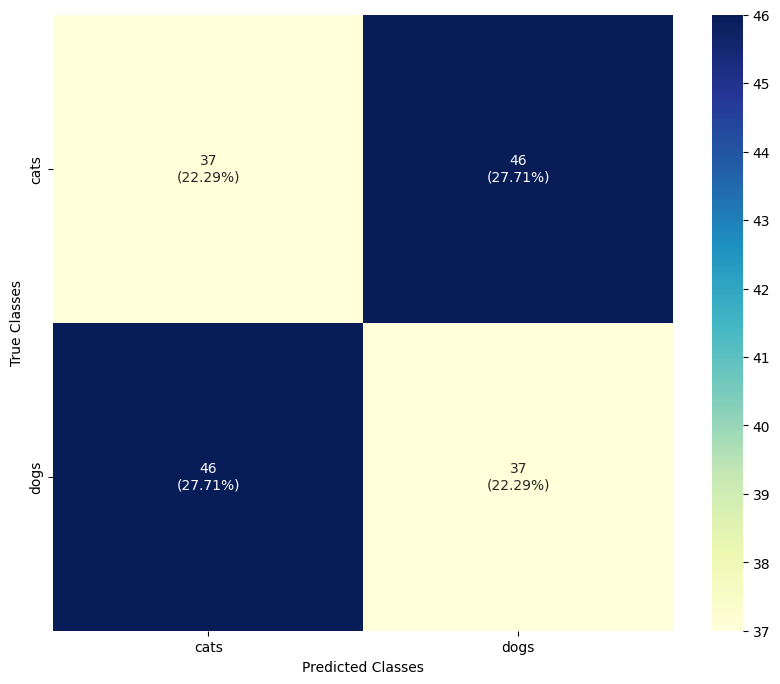

In [59]:
cm=confusion_matrix(y_valid, y_pred1)
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2,2)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

1/1 [==============================] - 0s 223ms/step


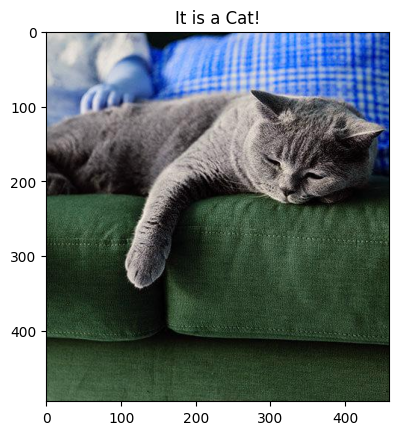

In [66]:
img="./CatDogImgData/test/cats/cat_114.jpg"
test_img = cv2.imread(img)
plt.imshow(test_img)
test_img = cv2.resize(test_img,image_size)
test_input = test_img.reshape((1,image_size[0],image_size[1],3))
pred=model1.predict(test_input)
if pred>=0.5:
    plt.title('It is a Dog!')
else:
    plt.title('It is a Cat!')

1/1 [==============================] - 0s 81ms/step


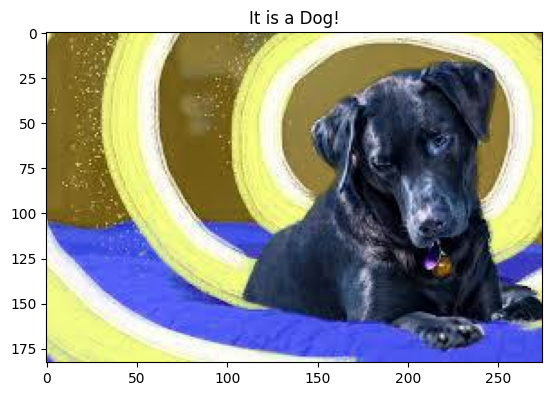

In [70]:
img="./CatDogImgData/test/dogs/dog_213.jpg"
test_img = cv2.imread(img)
plt.imshow(test_img)
test_img = cv2.resize(test_img,image_size)
test_input = test_img.reshape((1,image_size[0],image_size[1],3))
pred=model1.predict(test_input)
if pred>=0.5:
    plt.title('It is a Dog!')
else:
    plt.title('It is a Cat!')

In [71]:
print("Checking the wrong predictions:")
errors=((y_valid-y_pred1)!=0)
y_valid_errors = y_valid[errors]
y_pred1_errors = y_pred1[errors]
print("True value on error points:")
print(np.asarray(y_valid_errors))
print("Predicted values on error points:")
print(np.asarray(y_pred1_errors))

Checking the wrong predictions:
True value on error points:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predicted values on error points:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [72]:
val_imgs=valid_gen.filenames
val_img=np.asarray(val_imgs)[errors]
print("Validation images array (1st 10):")
print(val_img[:10])

Validation images array (1st 10):
['cats\\cat_100.jpg' 'cats\\cat_101.jpg' 'cats\\cat_102.jpg'
 'cats\\cat_104.jpg' 'cats\\cat_12.jpg' 'cats\\cat_129.jpg'
 'cats\\cat_138.jpg' 'cats\\cat_141.jpg' 'cats\\cat_149.jpg'
 'cats\\cat_151.jpg']


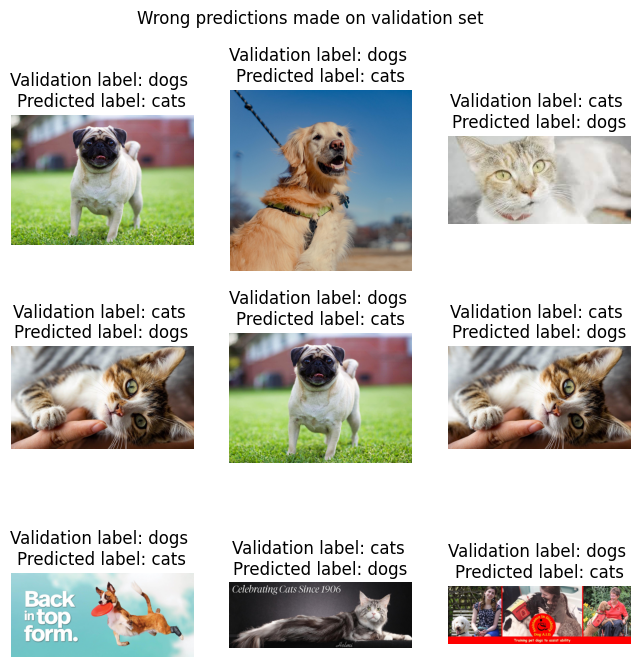

In [76]:
fig, ax = plt.subplots(3,3,figsize=(8,8))
idx=0
for i in range(3):
    for j in range(3):
        idx=np.random.randint(0, len(val_img))
        val_idx=y_valid_errors[idx]
        val_label=class_names[val_idx]
        pred_idx=y_pred1_errors[idx]
        pred_label=class_names[pred_idx]
        ax[i,j].set_title(f"Validation label: {val_label} \nPredicted label: {pred_label}")
        img_path=val_img[idx]
        img_path=os.path.join(train_dir, val_img[idx])
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i,j].imshow(img)
        ax[i,j].axis('off')
plt.suptitle('Wrong predictions made on validation set')
plt.show()

In [77]:
print("Checking the correct predictions:")
corrects=((y_valid-y_pred1)==0)
y_valid_corrects = y_valid[corrects]
y_pred1_corrects = y_pred1[corrects]
print("True value on correct points:")
print(np.asarray(y_valid_corrects))
print("Predicted values on correct points:")
print(np.asarray(y_pred1_corrects))

Checking the correct predictions:
True value on correct points:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predicted values on correct points:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [78]:
val_imgs=valid_gen.filenames
val_img=np.asarray(val_imgs)[corrects]
print("Validation images array (1st 10):")
print(val_img[:10])

Validation images array (1st 10):
['cats\\cat_10.jpg' 'cats\\cat_103.jpg' 'cats\\cat_11.jpg'
 'cats\\cat_111.jpg' 'cats\\cat_120.jpg' 'cats\\cat_123.jpg'
 'cats\\cat_13.jpg' 'cats\\cat_132.jpg' 'cats\\cat_133.jpg'
 'cats\\cat_134.jpg']


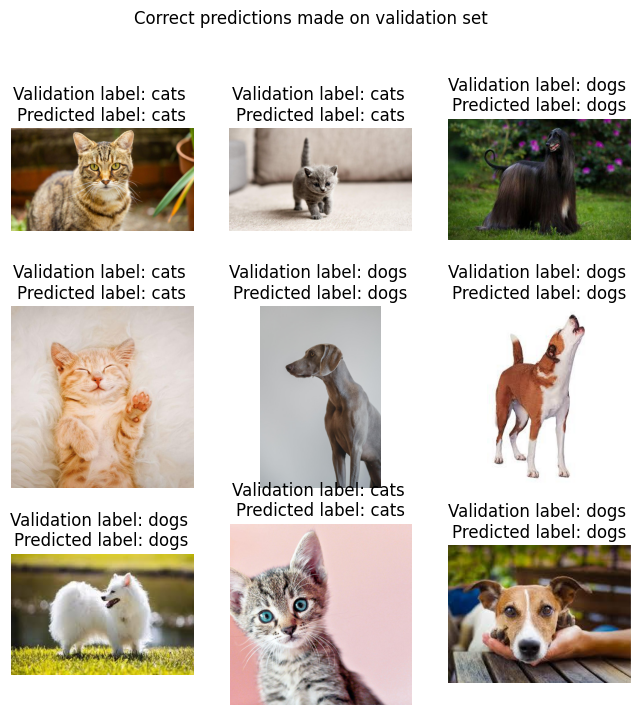

In [79]:
fig, ax = plt.subplots(3,3,figsize=(8,8))
idx=0
for i in range(3):
    for j in range(3):
        idx=np.random.randint(0, len(val_img))
        val_idx=y_valid_corrects[idx]
        val_label=class_names[val_idx]
        pred_idx=y_pred1_corrects[idx]
        pred_label=class_names[pred_idx]
        ax[i,j].set_title(f"Validation label: {val_label} \nPredicted label: {pred_label}")
        img_path=val_img[idx]
        img_path=os.path.join(train_dir, val_img[idx])
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i,j].imshow(img)
        ax[i,j].axis('off')
plt.suptitle('Correct predictions made on validation set')
plt.show()


Model 2

<!-- https://cainvas.ai-tech.systems/notebooks/details/?path=tanmay%2Fcatsvsdogs.ipynb -->

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
# from tensorflow.keras import layers
import cv2, os
# from tqdm import tqdm
# from random import shuffle
# import shutil

In [3]:
train_dir= "./BeeImgData/train"
test_dir= "./BeeImgData/test"

In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split= 0.2)

In [5]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(50,50), color_mode='grayscale', batch_size=20, class_mode='binary', subset= 'training')
val_generator = train_datagen.flow_from_directory(train_dir, target_size=(50,50), color_mode='grayscale', batch_size=20, class_mode='binary', subset= 'validation')

Found 3181 images belonging to 2 classes.
Found 795 images belonging to 2 classes.


In [6]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu',input_shape=(50,50,1), padding='same'))
# model.add(LeakyReLU(alpha=0.1))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
# model.add(tf.keras.activations.relu(alpha=0.1))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
# model.add(tf.keras.activations.relu(alpha=0.1))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
# model.add(tf.keras.activations.relu(alpha=0.1))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
# model.add(tf.keras.activations.relu(alpha=0.1))
model.add(Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,705 (877.75 KB)

 Trainable params: 224,705 (877.75 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Model Compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(train_generator, epochs = 2,verbose = 1,
                      validation_data = val_generator)

Epoch 1/2
160/160 ━━━━━━━━━━━━━━━━━━━━ 55s 306ms/step - accuracy: 0.9704 - loss: 0.0767 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/2
160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


In [ ]:
# model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history1 = model1.fit(train_set, epochs=5,verbose=1,
#                       validation_data=valid_set)

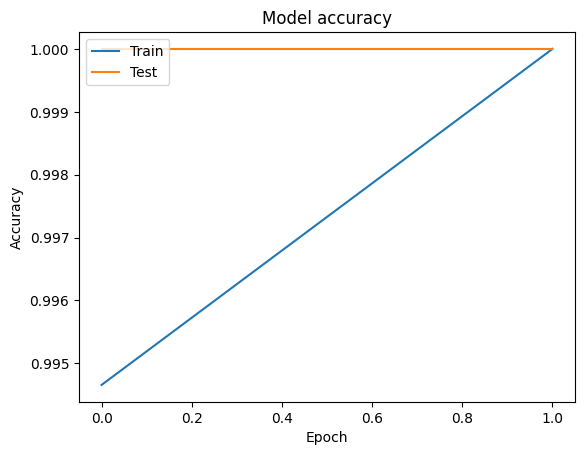

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

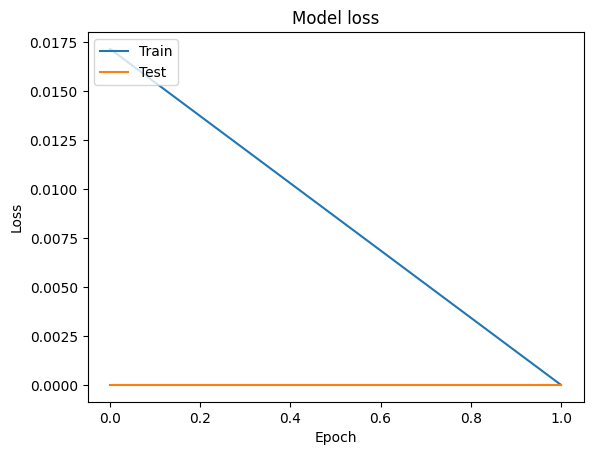

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# import matplotlib.pyplot as plt

# # Plot the loss curves
# plt.plot(history.history['loss'], color='red', linewidth=1, label='Train')
# plt.plot(history.history['val_loss'], color='blue', linewidth=5, label='Test')

# # Set the title, labels, and legend
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')

# # Show the plot
# plt.show()


In [11]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def Single_Image_Prediction(file):
#     image = load_img(file, color_mode='rgb', target_size=(128, 128))
    image = cv2.imread(file)
    plt.imshow(image)
    plt.show()
    image= cv2.resize(image, (50,50))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_arr = img_to_array(image)
    img_arr = img_arr/255.
    np_image = np.expand_dims(img_arr, axis=0)
    return np_image

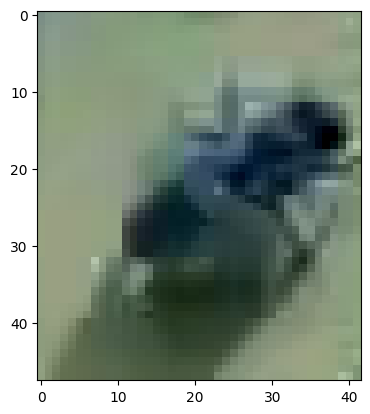

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
bee


In [12]:
image = Single_Image_Prediction('./BeeImgData/test/bees/038_115.png')
pred_value = model.predict(image)

if pred_value < 0.5:
    print('bee')
else:
    print('no bee')

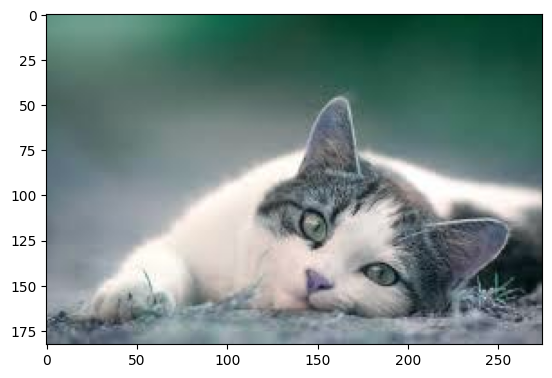

1/1 [==============================] - 0s 59ms/step
cat


In [14]:
image = Single_Image_Prediction('./CatDogImgData/test/cats/cat_140.jpg')
pred_value = model.predict(image)

if pred_value < 0.5:
    print('cat')
else:
    print('dog')

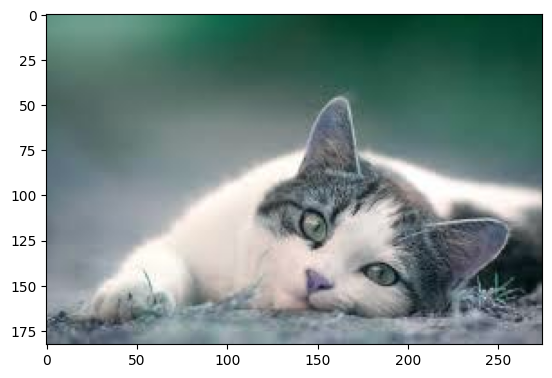

1/1 [==============================] - 0s 150ms/step


array([[0.46675098]], dtype=float32)

In [50]:
image = Single_Image_Prediction('./CatDogImgData/test/cats/cat_140.jpg')
pred_value = model.predict(image)
pred_value

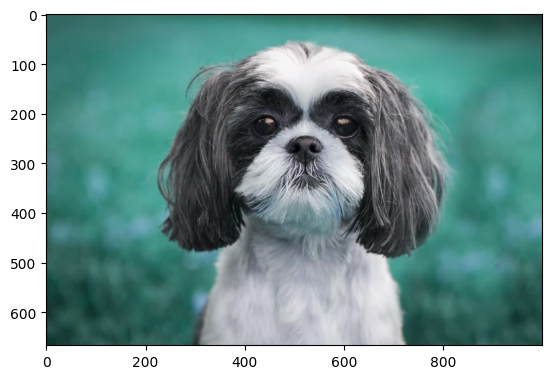

1/1 [==============================] - 0s 32ms/step


array([[0.5838738]], dtype=float32)

In [52]:
image = Single_Image_Prediction('./CatDogImgData/test/dogs/dog_150.jpg')
pred_value = model.predict(image)
pred_value

Model 3

In [54]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import  Conv2D , Dense , MaxPooling2D
from keras import Sequential

from keras.layers import Flatten

import matplotlib.pyplot as plt
import cv2

(168, 299, 3)

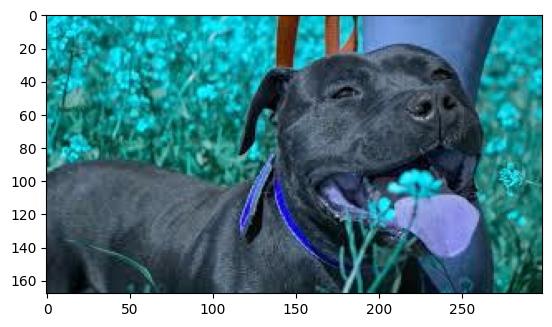

In [55]:
image = cv2.imread("./CatDogImgData/train/dogs/dog_103.jpg")
plt.imshow(image)
image.shape

In [56]:
train_ds=keras.utils.image_dataset_from_directory(
    directory="./CatDogImgData/train",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(256, 256),
)

test_ds=keras.utils.image_dataset_from_directory(
    directory="./CatDogImgData/test",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(256, 256),
)

Found 557 files belonging to 2 classes.
Found 140 files belonging to 2 classes.


In [57]:
def preprocess(image , label):
    image = tf.cast(image/255. , tf.float32)
    return image , label

In [58]:
train_ds=train_ds.map(preprocess)
test_ds=test_ds.map(preprocess)

In [59]:
model=Sequential()

model.add(Conv2D(32 , kernel_size=(3,3) , padding="valid" , activation ="relu" , input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2) , strides=2 , padding="valid"))

model.add(Conv2D(64 , kernel_size=(3,3) , padding="valid" , activation ="relu"))
model.add(MaxPooling2D(pool_size=(2,2) , strides=2 , padding="valid"))

model.add(Conv2D(128 , kernel_size=(3,3) , padding="valid" , activation ="relu" ))
model.add(MaxPooling2D(pool_size=(2,2) , strides=2 , padding="valid"))

model.add(Flatten())

model.add(Dense(120 , activation="relu"))
model.add(Dense(60 , activation="relu"))

model.add(Dense(1 , activation="sigmoid"))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 30, 30, 128)     

In [60]:

# import tensorflow as tf

# # Create a model with two output units
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), padding="valid", activation='relu', input_shape=(256, 256, 3)),
#     tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding="valid"),

#     tf.keras.layers.Conv2D(64, (3, 3), padding="valid", activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding="valid"),

#     tf.keras.layers.Conv2D(128, (3, 3), padding="valid", activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2), strides=2, padding="valid"),

#     tf.keras.layers.Flatten(),

#     tf.keras.layers.Dense(120, activation='relu'),
#     tf.keras.layers.Dense(60, activation='relu'),

#     # Output layer with two units and sigmoid activation function
#     tf.keras.layers.Dense(2, activation='sigmoid')
# ])

# # Compile the model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Load the training data
# train_ds = tf.keras.utils.image_dataset_from_directory(
#     directory="./CatDogImgData/train",
#     labels="inferred",
#     label_mode="int",
#     batch_size=32,
#     image_size=(256, 256),
# )

# # Train the model
# model.fit(train_ds, epochs=10)

# # Evaluate the model on the test data
# test_ds = tf.keras.utils.image_dataset_from_directory(
#     directory="./CatDogImgData/test",
#     labels="inferred",
#     label_mode="int",
#     batch_size=32,
#     image_size=(256, 256),
# )

# test_loss, test_accuracy = model.evaluate(test_ds)

# # Print the test accuracy
# print('Test accuracy:', test_accuracy)


In [61]:
model.compile(optimizer="adam" , loss="binary_crossentropy" , metrics =["accuracy"])

history = model.fit(train_ds , epochs=10 , validation_data=test_ds)

Epoch 1/10


18/18 [==============================] - 72s 4s/step - loss: 0.9073 - accuracy: 0.5153 - val_loss: 0.6994 - val_accuracy: 0.5000
Epoch 2/10
18/18 [==============================] - 66s 4s/step - loss: 0.6779 - accuracy: 0.5763 - val_loss: 0.7210 - val_accuracy: 0.5286
Epoch 3/10
18/18 [==============================] - 72s 4s/step - loss: 0.6595 - accuracy: 0.6050 - val_loss: 0.7075 - val_accuracy: 0.5429
Epoch 4/10
18/18 [==============================] - 68s 4s/step - loss: 0.6130 - accuracy: 0.6535 - val_loss: 0.7029 - val_accuracy: 0.6000
Epoch 5/10
18/18 [==============================] - 70s 4s/step - loss: 0.5056 - accuracy: 0.7379 - val_loss: 0.7099 - val_accuracy: 0.6071
Epoch 6/10
18/18 [==============================] - 72s 4s/step - loss: 0.4137 - accuracy: 0.8223 - val_loss: 0.7773 - val_accuracy: 0.6714
Epoch 7/10
18/18 [==============================] - 72s 4s/step - loss: 0.2535 - accuracy: 0.9084 - val_loss: 1.0903 - val_accuracy: 0.6571
Epoch 8/10
18/18 [=============

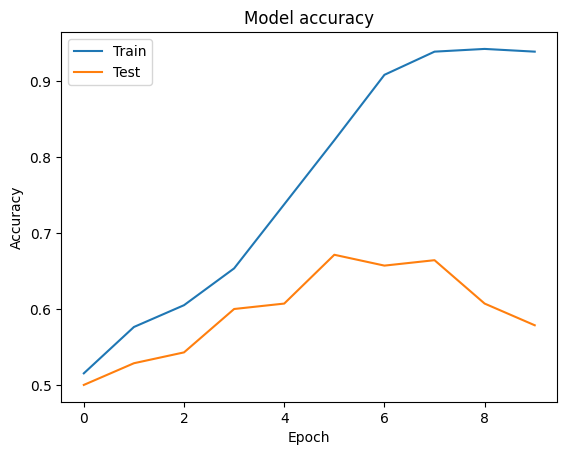

In [65]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

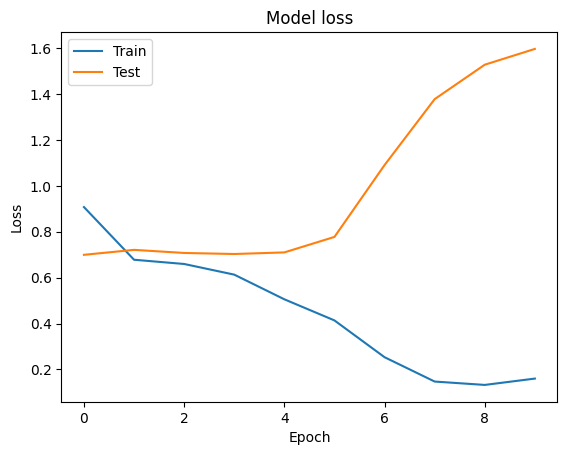

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

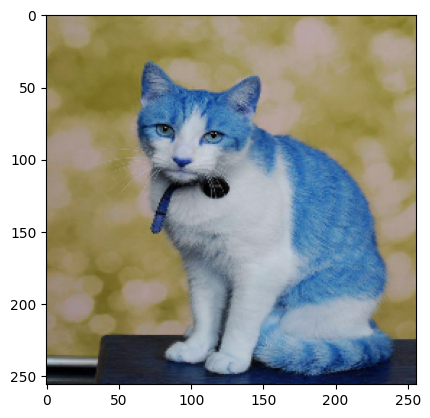

In [67]:
testimage1=cv2.imread("./CatDogImgData/test/cats/cat_1.jpg")
testimage1=cv2.resize(testimage1, (256,256))
testimage1_input=testimage1.reshape((1,256,256,3))

plt.imshow(testimage1)

In [34]:
print(model.predict(testimage1_input))

1/1 [==============================] - 0s 319ms/step
[[1.]]


1/1 [==============================] - 0s 197ms/step
[[0.]]


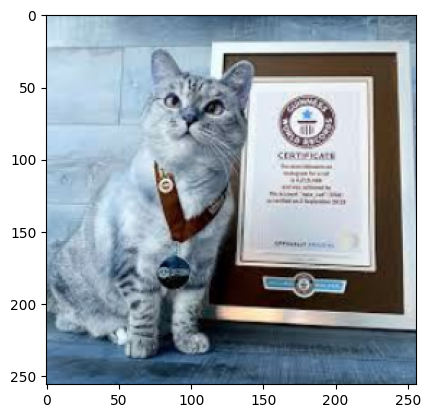

In [68]:
testimage1=cv2.imread("./CatDogImgData/test/cats/cat_124.jpg")
testimage1=cv2.resize(testimage1, (256,256))
testimage1_input=testimage1.reshape((1,256,256,3))

plt.imshow(testimage1)

print(model.predict(testimage1_input))

1/1 [==============================] - 0s 149ms/step
[[0.]]


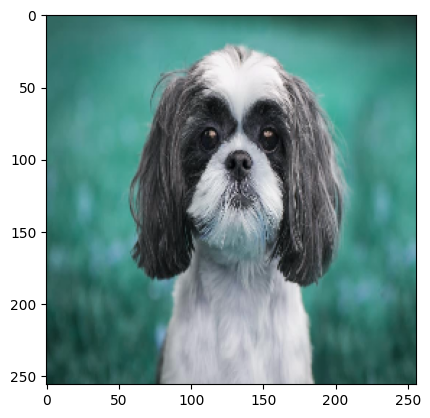

In [70]:
testimage1=cv2.imread("./CatDogImgData/test/dogs/dog_150.jpg")
testimage1=cv2.resize(testimage1, (256,256))
testimage1_input=testimage1.reshape((1,256,256,3))

plt.imshow(testimage1)

print(model.predict(testimage1_input))

Website Prediction

In [17]:
import tensorflow as tf
import numpy as np

# Load the pre-trained model
model = tf.keras.applications.ResNet50(weights='imagenet')

# Freeze the pre-trained model
model.trainable = False

# Add a new output layer to the pre-trained model
output = tf.keras.layers.Dense(2, activation='sigmoid')(model.output)

# Compile the model
model = tf.keras.Model(inputs=model.input, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam')

# Load the training data
train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')

# Train the model
model.fit(train_images, train_labels, epochs=10)

# Evaluate the model
test_images = np.load('test_images.npy')
test_labels = np.load('test_labels.npy')

test_loss, test_accuracy = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_accuracy)


102967424/102967424 [==============================] - 10s 0us/step


FileNotFoundError: [Errno 2] No such file or directory: 'train_images.npy'

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf

In [11]:
from warnings import filterwarnings
filterwarnings('ignore')

In [14]:
classifier = Sequential()
classifier.add(Conv2D(32,(3,3),input_shape=(64,64,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=2)) #if stride not given it equal to pool filter size
classifier.add(Conv2D(32,(3,3),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2,2),strides=2))
classifier.add(Flatten())
classifier.add(Dense(units=128,activation='relu'))
classifier.add(Dense(units=1,activation='sigmoid'))
adam = tensorflow.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
classifier.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])
#tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

ValueError: decay is deprecated in the new Keras optimizer, please check the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.Adam.

## bess

In [21]:
import os
import PIL
import zipfile
import shutil
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
import warnings
warnings.filterwarnings("ignore")
print("All the dependencies have been imported.")

# Update the dataset paths and class names
train = "./bee_imgs/train"
test = "./bee_imgs/test"
image_size = (256, 256)
batch_size = 32
class_names = ["bees", "no_bees"]

# Display some dataset information
train_files_count = len(os.listdir(train))
test_files_count = len(os.listdir(test))

print("Number of files in train folder:", train_files_count)
print("Number of files in test folder:", test_files_count)
print("Image size considered:", image_size)
print("Batch size considered:", batch_size)
print("Class Names:", class_names)

# Image Data Generator for preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # split for validation

test_datagen = ImageDataGenerator(rescale=1./255)

# Train and validation generators
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

# Test generator
test_generator = test_datagen.flow_from_directory(
    test,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

# Building the model
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))  # Binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Model training
# early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
# checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# history = model.fit(
#     train_generator,
#     epochs=25,
#     validation_data=validation_generator,
#     callbacks=[early_stop, checkpoint])

# Model training
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint])


# Evaluate the model
model.load_weights('best_model.h5')
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("Test accuracy:", test_acc)

# Plotting the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()





All the dependencies have been imported.
Number of files in train folder: 3976
Number of files in test folder: 1196
Image size considered: (256, 256)
Batch size considered: 32
Class Names: ['bees', 'no_bees']
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │    15,745,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,755,425 (60.10 MB)

 Trainable params: 15,755,425 (60.10 MB)

 Non-trainable params: 0 (0.00 B)

ValueError: Must provide at least one structure

All the dependencies have been imported.
Number of files in train folder: 3976
Number of files in test folder: 1196
Image size considered: (256, 256)
Batch size considered: 32
Class Names: ['bees', 'no_bees']
Found 3181 images belonging to 2 classes.
Found 795 images belonging to 2 classes.
Found 1196 images belonging to 2 classes.
Sample batch shape: (32, 256, 256, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    15,745,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,755,425 (60.10 MB)

 Trainable params: 15,755,425 (60.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9481 - loss: 0.0385
Epoch 1: val_loss improved from inf to 0.00000, saving model to best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.9485 - loss: 0.0381 - val_accuracy: 1.0000 - val_loss: 1.0556e-32
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 4.2807e-30
Epoch 2: val_loss did not improve from 0.00000
100/100 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 1.0000 - loss: 4.5215e-30 - val_accuracy: 1.0000 - val_loss: 1.9484e-30
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 1.1606e-28
Epoch 3: val_loss did not improve from 0.00000
100/100 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 1.0000 - loss: 1.1584e-28 - val_accuracy: 1.0000 - val_loss: 4.5862e-31
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 1.0000 - loss: 2.6173e-29
Epoch 4: val_loss did not improve from 0.00000
100/100 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 1.

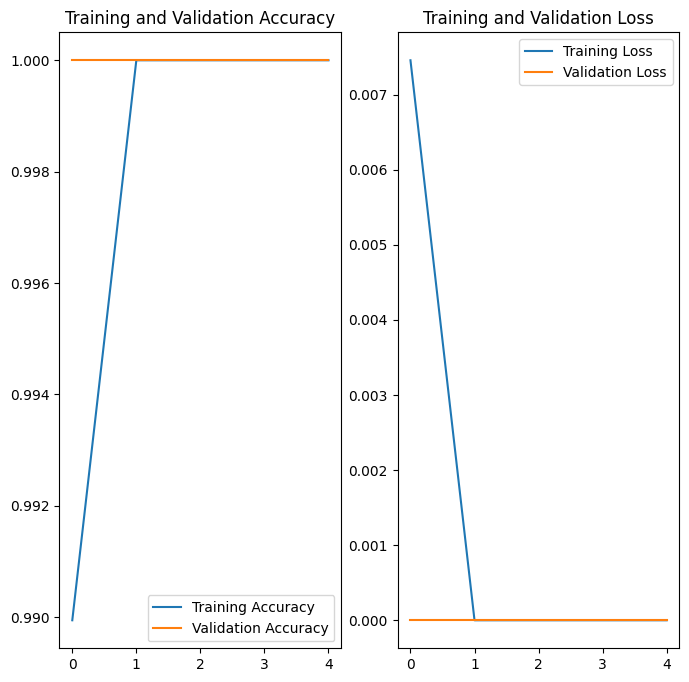

In [1]:
import os
import PIL
import zipfile
import shutil
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
import warnings
warnings.filterwarnings("ignore")
print("All the dependencies have been imported.")

# Update the dataset paths and class names
train = "./bee_imgs/train"
test = "./bee_imgs/test"
image_size = (256, 256)
batch_size = 32
class_names = ["bees", "no_bees"]

# Display some dataset information
train_files_count = sum([len(files) for r, d, files in os.walk(train)])
test_files_count = sum([len(files) for r, d, files in os.walk(test)])

print("Number of files in train folder:", train_files_count)
print("Number of files in test folder:", test_files_count)
print("Image size considered:", image_size)
print("Batch size considered:", batch_size)
print("Class Names:", class_names)

# Image Data Generator for preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # split for validation

test_datagen = ImageDataGenerator(rescale=1./255)

# Train and validation generators
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

# Test generator
test_generator = test_datagen.flow_from_directory(
    test,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

# Verify data generators by displaying a few batch samples
sample_batch = next(train_generator)
print("Sample batch shape:", sample_batch[0].shape)

# Building the model
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))  # Binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Model training
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint])

# Evaluate the model
model.load_weights('best_model.keras')
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("Test accuracy:", test_acc)

# Plotting the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [1]:
import os
import PIL
import zipfile
import shutil
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
import warnings
warnings.filterwarnings("ignore")
print("All the dependencies have been imported.")

# Update the dataset paths and class names
train = "./BeeImgData/train"
test = "./BeeImgData/test"
image_size = (256, 256)
batch_size = 32
class_names = ["bees", "no_bees"]

# Display some dataset information
train_files_count = sum([len(files) for r, d, files in os.walk(train)])
test_files_count = sum([len(files) for r, d, files in os.walk(test)])

print("Number of files in train folder:", train_files_count)
print("Number of files in test folder:", test_files_count)
print("Image size considered:", image_size)
print("Batch size considered:", batch_size)
print("Class Names:", class_names)

# Image Data Generator for preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # split for validation

test_datagen = ImageDataGenerator(rescale=1./255)

# Train and validation generators
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

# Test generator
test_generator = test_datagen.flow_from_directory(
    test,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary')

# Verify data generators by displaying a few batch samples
sample_batch = next(train_generator)
print("Sample batch shape:", sample_batch[0].shape)

# Building the model
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))  # Binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Model training
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint])

# Evaluate the model
model.load_weights('best_model.keras')
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("Test accuracy:", test_acc)

# Plotting the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


All the dependencies have been imported.
Number of files in train folder: 3976
Number of files in test folder: 1196
Image size considered: (256, 256)
Batch size considered: 32
Class Names: ['bees', 'no_bees']
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Sample batch shape: (0, 256, 256, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    15,745,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,755,425 (60.10 MB)

 Trainable params: 15,755,425 (60.10 MB)

 Non-trainable params: 0 (0.00 B)

ValueError: Must provide at least one structure